Group  body
Average performance
Sciddo F1  0.5754876056734092
PePr F1  0.5462353996881651
Sciddo Acc  0.6455995014351368
PePr Acc  0.5764536981733115
Group  body & 3+ enh.
Average performance
Sciddo F1  0.5908610506954306
PePr F1  0.5466757809800562
Sciddo Acc  0.6920137909970867
PePr Acc  0.5773100507471102


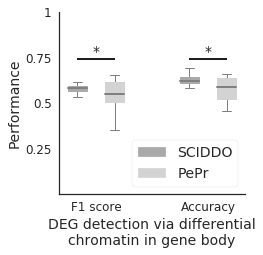

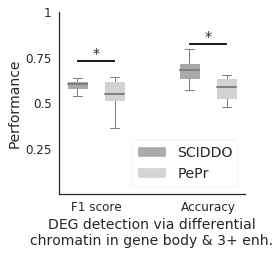

In [1]:
%matplotlib inline

import os as os
import csv as csv
import collections as collect
import operator as op
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import sklearn as skl
import sklearn.metrics as sklm
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot performance bar charts for
# PePr and SCIDDO based on DE/stable
# gene overlaps with HSPs and DPs

date = '20180922'

run_hsp_pepr_perf = True

save_figures = True
diss_version = True

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['penem', 'ordem', 'penrep', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

isect_root = os.path.join(fhgfs_base, 'bedtools', 'deep', 'pepr_locus_isect')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
genetrail_out = os.path.join(fhgfs_base, 'statediff/genetrail/input_lists')
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'


def compute_sciddo_performance(dataset, assoc_enh, fc, pv, enh_type='any'):
    
    enh_types = {'any': ('total_enh', 'total_hits'),
                 'intra': ('intra_enh', 'intra_hits'),
                 'inter': ('inter_enh', 'inter_hits')}
    enh_select, enh_hits = enh_types[enh_type]
    
    perf_scores = []
    applicable = []
    full_size = dataset.shape[0]
    for num_enh in assoc_enh:        
        subset = dataset.loc[dataset[enh_select] > num_enh, :].copy()
        
        subset['true'] = 0
        
        not_outliers = np.array(subset['padj'] > -1, dtype=np.bool)
        higher_fc = np.array(subset['log2fc'].abs() > fc, dtype=np.bool)
        lower_pv = np.array(subset['padj'] < pv, dtype=np.bool)
        
        is_deg = np.logical_and(higher_fc, lower_pv)
        is_deg = np.logical_and(is_deg, not_outliers)
        
        subset.loc[is_deg, 'true'] = 1
            
        subset['pred'] = 0
        select_dc = np.logical_and(subset['body_hit'] > 0,
                                   subset[enh_hits] > num_enh)
        subset.loc[select_dc, 'pred'] = 1
        perf_scores.append(sklm.f1_score(subset['true'],
                                         subset['pred'],
                                         average='macro'))
        perf_scores.append(sklm.accuracy_score(subset['true'],
                                               subset['pred']))
        applicable.append((subset.shape[0], subset.shape[0] / dataset.shape[0]))
            
    return perf_scores, applicable


def compute_pepr_performance(dataset, assoc_enh, fc, pv, s1, s2, enh_type='any'):

    enh_types = {'any': ('total_enh', 'diff_total'),
                 'intra': ('intra_enh', 'diff_intra'),
                 'inter': ('inter_enh', 'diff_inter')}
    enh_select, enh_hits = enh_types[enh_type]
    
    # add diff body indicator
    s1 += '-H3K36me3'
    s2 += '-H3K36me3'
    dataset['body_diff'] = 0
    select_b0 = np.logical_and(dataset[s1] == 0, dataset[s2] > 0)
    select_b1 = np.logical_and(dataset[s1] > 0, dataset[s2] == 0)
    select_db = np.logical_or(select_b0, select_b1)
    dataset.loc[select_db, 'body_diff'] = 1
    
    perf_scores = []
    for num_enh in assoc_enh:
        subset = dataset.loc[dataset[enh_select] > num_enh, :].copy()
                
        subset['true'] = 0
        
        not_outliers = np.array(subset['padj'] > -1, dtype=np.bool)
        higher_fc = np.array(subset['log2fc'].abs() > fc, dtype=np.bool)
        lower_pv = np.array(subset['padj'] < pv, dtype=np.bool)
        
        is_deg = np.logical_and(higher_fc, lower_pv)
        is_deg = np.logical_and(is_deg, not_outliers)
        
        subset.loc[is_deg, 'true'] = 1
    
        subset['pred'] = 0
        select_dc = np.logical_and(subset['body_diff'] > 0,
                                   subset[enh_hits] > num_enh)
        subset.loc[select_dc, 'pred'] = 1
        perf_scores.append(sklm.f1_score(subset['true'],
                                         subset['pred'],
                                         average='macro'))
        perf_scores.append(sklm.accuracy_score(subset['true'],
                                               subset['pred']))
    return perf_scores


def plot_perf_box_charts(data, grp_num, fkey, save_diss):
    
    groups = {'g1': 'body', 'g2': 'body & 3+ enh.'}
    group_label = groups[grp_num]
    print('Group ', group_label)
    
    num_rows = 1
    num_cols = 1
    fig, ax = plt.subplots(figsize=fig_sizes['one_col']['square'],
                           nrows=num_rows, ncols=num_cols,
                           sharex=True, sharey=True)

    box_xpos = [1, 2, 4, 5]    
    box_colors = ['dimgrey', 'white', 'dimgrey', 'white']
    
    f1_sciddo = data['sciddo_{}_f1'.format(grp_num)]
    f1_pepr = data['pepr_{}_f1'.format(grp_num)]
    
    acc_sciddo = data['sciddo_{}_acc'.format(grp_num)]
    acc_pepr = data['pepr_{}_acc'.format(grp_num)]
    
    boxcolor = 'grey'
    medcolor = 'grey'
    median_props = {'color': medcolor, 'linewidth': 2}
    box_props = {'color': boxcolor, 'linewidth': 1}
    whisker_props = {'color': boxcolor, 'linewidth': 1}
    cap_props = {'color': boxcolor, 'linewidth': 1}
    
    boxes = ax.boxplot([f1_sciddo, f1_pepr, acc_sciddo, acc_pepr], sym="",
                       labels=None, medianprops=median_props, boxprops=box_props,
                       whiskerprops=whisker_props, capprops=cap_props,
                       positions=box_xpos, patch_artist=True)
    
    ax.set_ylim(0, 1)
    yticks = [0.25, 0.5, 0.75, 1]
    ax.set_yticks(yticks)
    ax.set_yticklabels(list(map(str, yticks)), fontsize=12)
    
    xticks = [1.5, 4.5]
    ax.set_xticks(xticks)
    ax.set_xticklabels(['F1 score', 'Accuracy'], fontsize=12)
    
    current, next_one = 'darkgrey', 'lightgrey'
    for b in boxes['boxes']:
        plt.setp(b, color=current)
        current, next_one = next_one, current
        
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if not save_diss:
        tt = ax.set_title(fkey, fontsize=16)
        tt.set_position((0.03, 1.015))
        
    leg_patches = []
    leg_patches.append(mpatches.Patch(facecolor='darkgrey', label='SCIDDO', ec='white'))
    leg_patches.append(mpatches.Patch(facecolor='lightgrey', label='PePr', ec='white'))
    
    leg = ax.legend(handles=leg_patches,
                    loc='lower right',
                    fontsize=14, frameon=True)
    
    if not fkey.startswith('S'):
        ax.hlines([0.74, 0.74], [1, 4], [2, 5],
                  colors='black', linestyles='solid')
        pv_f1 = stats.mannwhitneyu(f1_sciddo, f1_pepr, alternative='greater')[1]
        assert pv_f1 < 0.01, 'PV F1 changed'
        ax.text(1.4, 0.76, '*', fontdict={'fontsize': 14})
        
        pv_acc = stats.mannwhitneyu(acc_sciddo, acc_pepr, alternative='greater')[1]
        assert pv_acc < 0.01, 'PV acc changed'
        ax.text(4.4, 0.76, '*', fontdict={'fontsize': 14})
    else:
        ax.hlines([0.73, 0.82], [1, 4], [2, 5],
                  colors='black', linestyles='solid')
        pv_f1 = stats.mannwhitneyu(f1_sciddo, f1_pepr, alternative='greater')[1]
        assert pv_f1 < 0.01, 'PV F1 changed'
        ax.text(1.4, 0.75, '*', fontdict={'fontsize': 14})
        
        pv_acc = stats.mannwhitneyu(acc_sciddo, acc_pepr, alternative='greater')[1]
        assert pv_acc < 0.01, 'PV acc changed'
        ax.text(4.4, 0.84, '*', fontdict={'fontsize': 14})
        
    ax.set_ylabel('Performance', fontsize=14)
    ax.set_xlabel('DEG detection via differential\nchromatin in gene {}'.format(group_label), fontsize=14)
    
    print('Average performance')
    print('Sciddo F1 ', np.average(f1_sciddo))
    print('PePr F1 ', np.average(f1_pepr))
    print('========')
    print('Sciddo Acc ', np.average(acc_sciddo))
    print('PePr Acc ', np.average(acc_pepr))
    
    return fig, []
            


def plot_hsp_pepr_perf():
    # use cached data from other notebooks
    hsp_ovl_cache = os.path.join(cache_dir, '20180921_plot_gene-enh-hsp_tpm-bin.h5')
    if not os.path.isfile(hsp_ovl_cache):
        raise RuntimeError('No cached data for HSP overlaps')
    pepr_ovl_cache = os.path.join(cache_dir, '20180921_plot_gene-enh-pepr_tpm-bin.h5')
    if not os.path.isfile(pepr_ovl_cache):
        raise RuntimeError('No cached data for PePr overlaps')

    for seg in segmentations:
        if seg != 'cmm18':
            continue
        for score in scorings:
            if score != 'penem':
                continue
            sciddo_data = dict()
            with pd.HDFStore(hsp_ovl_cache, 'r') as hdf:
                load_keys = sorted([k for k in hdf.keys() if seg in k and score in k])
                for k in load_keys:
                    comp = os.path.split(k)[-1]
                    if comp == 'Liver_vs_Blood':
                        continue
                    sciddo_data[comp] = hdf[k]
            pepr_data = dict()
            with pd.HDFStore(pepr_ovl_cache, 'r') as hdf:
                for k in hdf.keys():
                    comp = os.path.split(k)[-1]
                    pepr_data[comp] = hdf[k]
            perf_table = []
            perf_columns = ['sample1', 'sample2', 'enh_loc', 'fc', 'pv',
                            'sciddo_g1_f1', 'sciddo_g1_acc', 'pepr_g1_f1', 'pepr_g1_acc',
                            'num_g1', 'pct_g1',
                            'sciddo_g2_f1', 'sciddo_g2_acc', 'pepr_g2_f1', 'pepr_g2_acc',
                            'num_g2', 'pct_g2']
            for fk, enh_type in zip(['12'], ['any']):
                
                comparisons = sorted(sciddo_data.keys())
                gene_enhancer = [-1, 2]
                for comp in comparisons:
                    s1, s2 = comp.split('_vs_')
                    for fc in [0.5, 1, 2, 4]:
                        
                        for p in [0.001, 0.01, 0.05, 0.1]:
                            sciddo_y, target_cov = compute_sciddo_performance(sciddo_data[comp], gene_enhancer,
                                                                              fc, p, enh_type)
                            pepr_y = compute_pepr_performance(pepr_data[comp], gene_enhancer,
                                                              fc, p, s1, s2, enh_type)
                            
                            row = [s1, s2, enh_type, fc, p, sciddo_y[0], sciddo_y[1],
                                   pepr_y[0], pepr_y[1], target_cov[0][0], target_cov[0][1],
                                   sciddo_y[2], sciddo_y[3], pepr_y[2], pepr_y[3],
                                   target_cov[1][0], target_cov[1][1]]
                            perf_table.append(row)
                df = pd.DataFrame(perf_table, columns=perf_columns)
                
                for group in ['g1', 'g2']:
                    fkeys = {'g1': '12', 'g2': 'S7'}
                    fk = fkeys[group]
                    fig, exart = plot_perf_box_charts(df, group, fk, diss_version)
                    if save_figures:
                        outname = 'fig_{}_hsp_pepr_perf_enh-{}-{}_{}_{}'.format(fk, enh_type, group, seg, score)
                        if fk.startswith('S'):
                            out_folder = fig_supp
                        else:
                            out_folder = fig_main

                        if diss_version:
                            out_folder = fig_diss

                        out_pdf = os.path.join(out_folder, outname + '.pdf')
                        fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)

                        if not diss_version:
                            out_png = os.path.join(out_folder, outname + '.png')
                            fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
                
    return


if run_hsp_pepr_perf:
    plot_hsp_pepr_perf()
